In [30]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import itertools
import collections 
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

In [64]:
# import data sets
path = "games.csv" 
games_df = pd.read_csv(path)

games_details_df = pd.read_csv("games_details.csv")
games_details_df_og = games_details_df.copy()

players_df = pd.read_csv("players.csv")
teams_df = pd.read_csv("teams.csv")
ranking_df = pd.read_csv("ranking.csv")
player_supp_df = pd.read_csv("player_supplementary_data.csv")

In [65]:
print(games_details_df['START_POSITION'].notnull().sum())
len(games_details_df['PLAYER_NAME'].unique())
positions = games_details_df[games_details_df['PLAYER_NAME'] == 'Tremont Waters']['START_POSITION'].unique()

231035
yes G


In [60]:
unique_players = set(players_df['PLAYER_ID'])
unique_players_from_games = set(games_details_df['PLAYER_ID'])

unique_players_names = set(players_df['PLAYER_NAME'])
unique_players_names_from_games = set(games_details_df['PLAYER_NAME'])

print("No. player names in players df:", len(list(unique_players_names)))
print("No. player names in games df:", len(list(unique_players_names_from_games)))
print(len(list(unique_players_names_from_games - unique_players_names)))
print("No. player IDs in players df:", len(list(unique_players)))
print("No. player IDs in games df:", len(list(unique_players_from_games)))
print(len(list(unique_players_from_games - unique_players)))

games_details_df[games_details_df['PLAYER_ID'] == 1627734].shape

No. player names in players df: 1749
No. player names in games df: 2407
658
No. player IDs in players df: 1769
No. player IDs in games df: 2434
665


(371, 28)

In [81]:
players_to_positions = {}

for player_name in unique_players_names_from_games:
    positions = games_details_df[games_details_df['PLAYER_NAME'] == player_name]['START_POSITION'].unique()
    for p in positions:
        if type(p) is str:
            players_to_positions[player_name] = p
            break

In [67]:
# add FGL, FG3L, FTL columns
games_details_df['FGL'] = games_details_df['FGA']-games_details_df['FGM']
games_details_df['FG3L'] = games_details_df['FG3A']-games_details_df['FG3M']
games_details_df['FTL'] = games_details_df['FTA']-games_details_df['FTM']

In [68]:
# change minutes from strong form to floats
df_temp = games_details_df['MIN'].str.split(':', expand=True).astype(float)
games_details_df['MIN_NUM'] = df_temp[0] 

In [70]:
games_details_df_copy = games_details_df.copy()

In [212]:
# SET UP 
# construct a new df to hold player and game data where each row represents a player
# and the columns include averaged data from games this df will be used for clustering 
games_details_df = games_details_df_copy.copy()

# 1. CREATE PLAYER_AVGS_DF
add_positions = False
if add_positions:
    games_details_df = games_details_df.dropna(subset=['START_POSITION'])
    player_avgs_df = games_details_df.groupby('PLAYER_ID').agg({'PLAYER_NAME':'first', 'START_POSITION': 'first', 'FGM':'mean', 'FG3M':'mean','FTM':'mean',
                                                       'OREB':'mean', 'DREB':'mean', 'AST':'mean', 'STL':'mean',
                                                       'BLK':'mean', 'TO':'mean', 'PF':'mean', 'PTS':'mean',
                                                       'PLUS_MINUS':'mean', 'FGL':'mean', 'FG3L':'mean', 
                                                       'FTL':'mean', 'MIN_NUM':'mean'}).reset_index()
    player_avgs_df = player_avgs_df.replace('None', np.nan)
    player_avgs_df['position'] = np.nan

else:
    player_avgs_df = games_details_df.groupby('PLAYER_ID').agg({'PLAYER_NAME':'first', 'START_POSITION': 'first', 'FGM':'mean', 'FG3M':'mean','FTM':'mean',
                                                       'OREB':'mean', 'DREB':'mean', 'AST':'mean', 'STL':'mean',
                                                       'BLK':'mean', 'TO':'mean', 'PF':'mean', 'PTS':'mean',
                                                       'PLUS_MINUS':'mean', 'FGL':'mean', 'FG3L':'mean', 
                                                       'FTL':'mean', 'MIN_NUM':'mean'}).reset_index()
    print(player_avgs_df['START_POSITION'].unique(), player_avgs_df.shape)      
    player_avgs_df['position'] = np.nan

position = None
if position == None:
    player_avgs_df = player_avgs_df
else:
    player_avgs_df = player_avgs_df[player_avgs_df.START_POSITION == position]

two_positions = False
if two_positions: 
    player_avgs_df = player_avgs_df[(player_avgs_df.START_POSITION == 'G') | (player_avgs_df.START_POSITION == 'C')]

# 3. FEATURE SELECTION - REMOVE REDUNDANT COLUMNS
player_avgs_df = player_avgs_df.drop(columns = ['MIN_NUM', 'FGM', 'position'])
print("Number of features is now:", len(player_avgs_df.columns) - 1)
print(player_avgs_df.columns)

# 4. PERFORM DATA IMPUTATION
imputed_player_avgs = KNNImputer().fit_transform(player_avgs_df.drop(columns = ['PLAYER_ID', 'PLAYER_NAME', 'START_POSITION'], axis=1))
imputed_player_avgs_df = pd.DataFrame(imputed_player_avgs, index=player_avgs_df.drop(columns = ['PLAYER_ID', 'PLAYER_NAME', 'START_POSITION'], axis=1).index, columns=player_avgs_df.drop(columns = ['PLAYER_ID', 'PLAYER_NAME', 'START_POSITION'], axis=1).columns)
imputed_player_avgs_df['PLAYER_ID'] = player_avgs_df['PLAYER_ID']
print("Imputed player averages df shape", imputed_player_avgs_df.shape)

# 5. NORMALIZE THE MATRIX
scaler = preprocessing.StandardScaler().fit(imputed_player_avgs_df.drop(columns=['PLAYER_ID'], axis=1))
norm_player_avgs_df = scaler.transform(imputed_player_avgs_df.drop(columns=['PLAYER_ID'], axis=1))
print("Normalized matrix shape", norm_player_avgs_df.shape)


['G' None 'F' 'C'] (2434, 19)
Number of features is now: 16
Index(['PLAYER_ID', 'PLAYER_NAME', 'START_POSITION', 'FG3M', 'FTM', 'OREB',
       'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS', 'FGL',
       'FG3L', 'FTL'],
      dtype='object')
Imputed player averages df shape (2434, 15)
Normalized matrix shape (2434, 14)


Shape of matrix beforehand: (2434, 14)


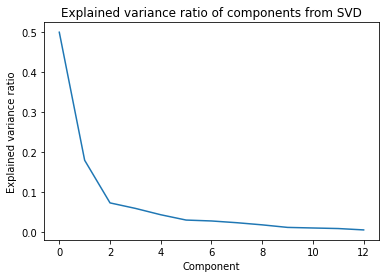

(2434,)
Top features in component 1:
PTS
FGL
TO
FTM
DREB
Top features in component 2:
OREB
BLK
FTL
DREB
PF
Top features in component 3:
FTL
TO
AST
PF
FTM
Top features in component 4:
PLUS_MINUS
FTL
AST
FTM
STL
Top features in component 5:
FTL
FTM
PTS
FG3M
FG3L
Top features in component 6:
STL
FTL
FG3L
PF
FG3M
Top features in component 7:
BLK
STL
AST
FTL
FG3L
Top features in component 8:
PF
BLK
TO
FTL
PLUS_MINUS
Top features in component 9:
FTL
AST
TO
OREB
DREB
Top features in component 10:
DREB
TO
FGL
PLUS_MINUS
STL
Top features in component 11:
TO
STL
OREB
FG3L
PLUS_MINUS
Top features in component 12:
FGL
FG3L
PLUS_MINUS
FTL
BLK
Top features in component 13:
FG3L
FTM
DREB
OREB
AST


In [213]:
# 6. DIMENSIONALITY REDUCTION

# 6a. SVD
print("Shape of matrix beforehand:", norm_player_avgs_df.shape)
svd = TruncatedSVD(n_components = 13, random_state = 1)
svd.fit(norm_player_avgs_df)
plt.plot(svd.explained_variance_ratio_)
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')
plt.title('Explained variance ratio of components from SVD')
plt.show()

svd_top_2_comp = svd.fit_transform(norm_player_avgs_df)
print(svd_top_2_comp[:,0].shape)

# look at composition of the components
topK = 5
for i in range(svd.components_.shape[0]):
    print(f'Top features in component {i+1}:')
    ranks = np.argsort(svd.components_[i])[::-1][:topK]
    for j in range(topK):
        print(imputed_player_avgs_df.columns[ranks[j]])

([<matplotlib.axis.XTick at 0x7f9dedbaff10>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

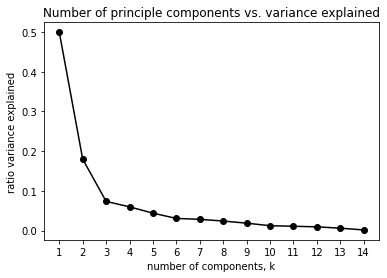

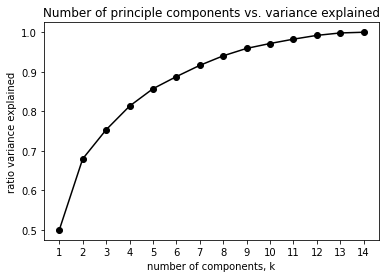

In [214]:
# 6b. PCA
pca = PCA(n_components = norm_player_avgs_df.shape[1]).fit(norm_player_avgs_df)
pca_player_avgs =PCA(n_components = 6).fit_transform(norm_player_avgs_df)

ks = range(1,norm_player_avgs_df.shape[1]+1)
plt.figure(1)
plt.plot(ks, pca.explained_variance_ratio_, '-o', color='black')
plt.xlabel('number of components, k')
plt.ylabel('ratio variance explained')
plt.title('Number of principle components vs. variance explained')
plt.xticks(ks)

plt.figure(2)
out_sum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(ks, out_sum, '-o', color='black')
plt.xlabel('number of components, k')
plt.ylabel('ratio variance explained')
plt.title('Number of principle components vs. variance explained')
plt.xticks(ks)

In [207]:
pca_components = np.abs(pca.components_)
columns = imputed_player_avgs_df.columns
indeces = np.argsort(pca_components[0])[-5:]
print(columns[indeces])
indeces = np.argsort(pca_components[1])[-5:]
print(columns[indeces])

Index(['DREB', 'FTM', 'TO', 'FGL', 'PTS'], dtype='object')
Index(['FTL', 'FG3M', 'BLK', 'FG3L', 'OREB'], dtype='object')


(2434, 13)
(2434, 6)


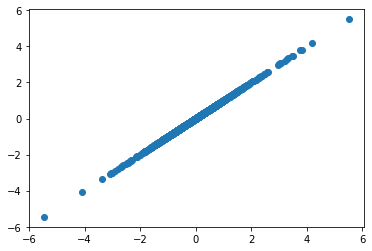

In [215]:
# PCA vs SVD
print(svd_top_2_comp.shape)
print(pca_player_avgs.shape)
plt.scatter(svd_top_2_comp[:, 4], pca_player_avgs[:, 4])

/Users/hannah/Documents/424/424/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


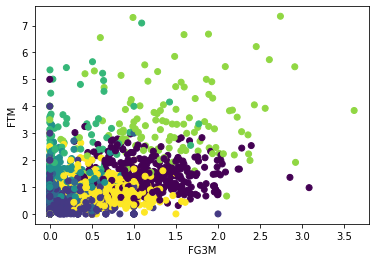

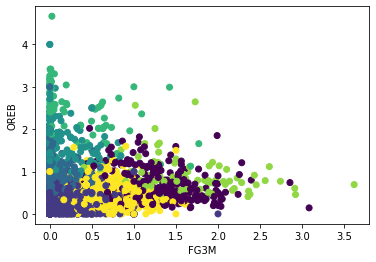

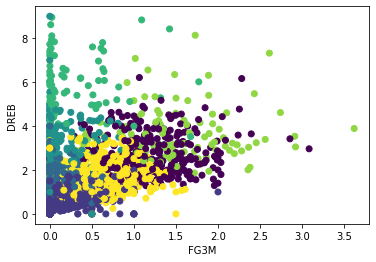

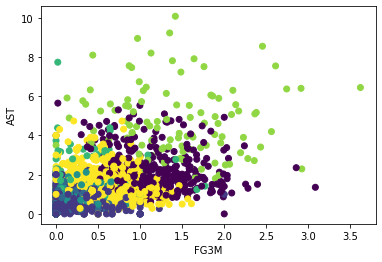

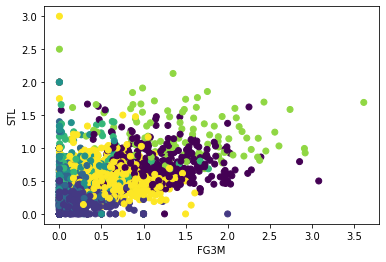

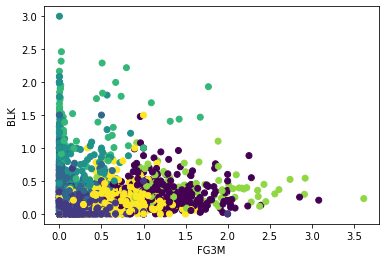

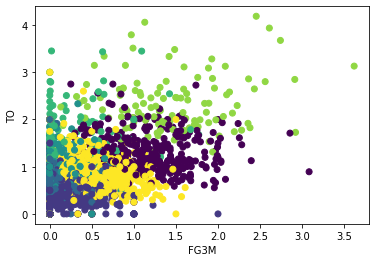

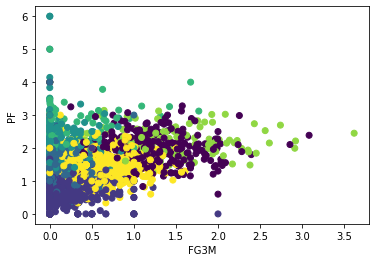

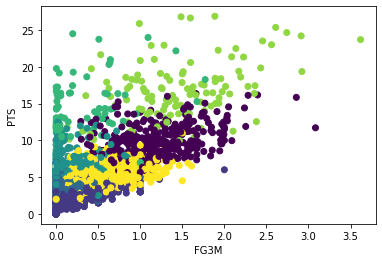

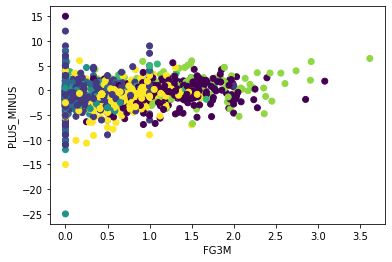

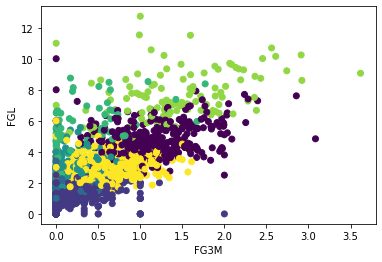

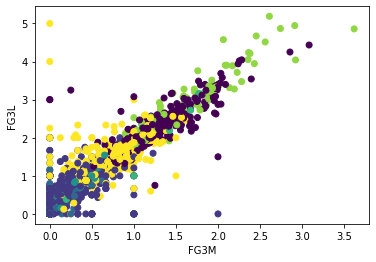

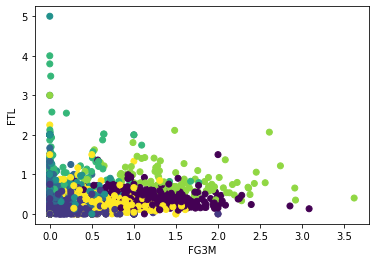

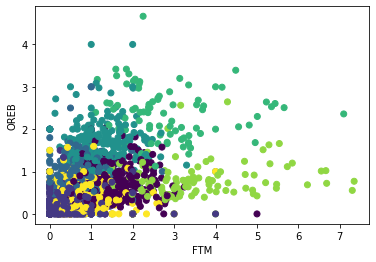

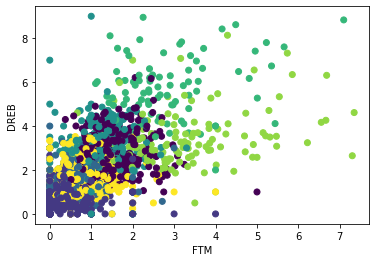

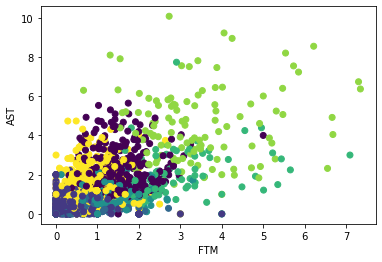

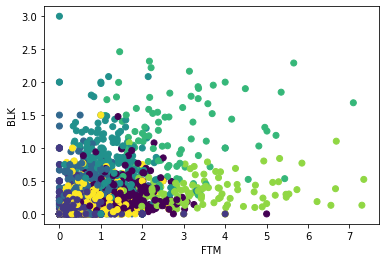

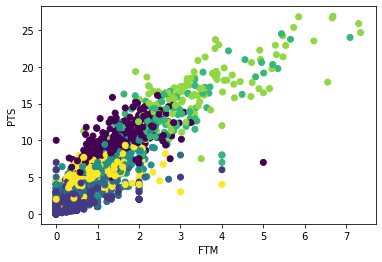

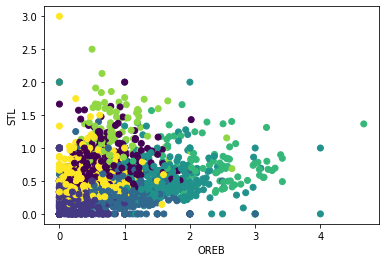

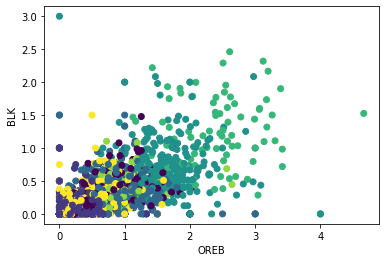

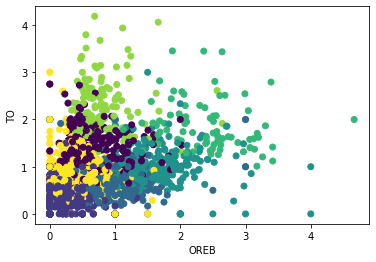

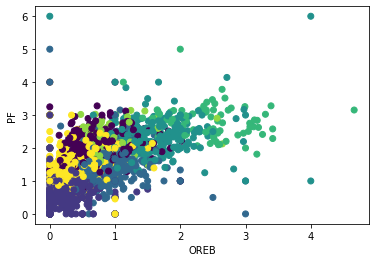

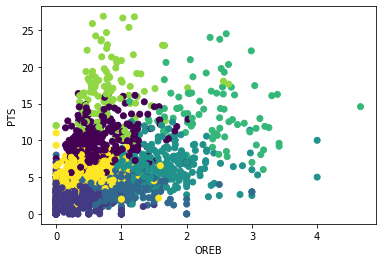

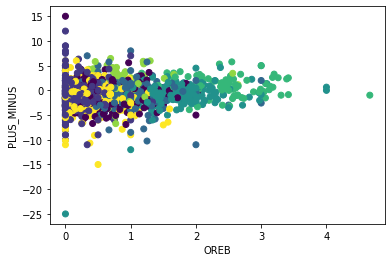

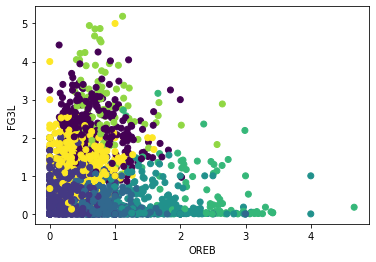

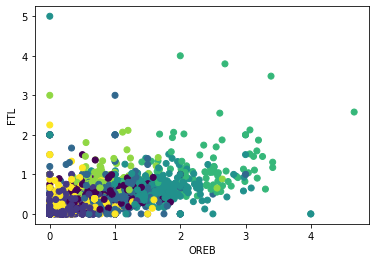

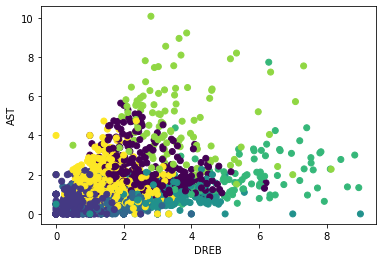

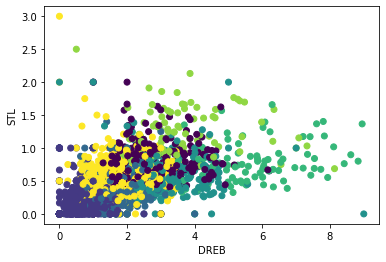

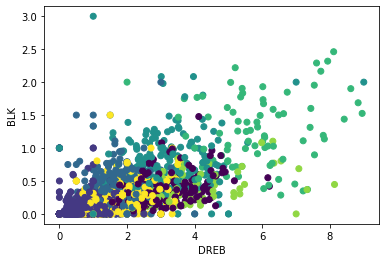

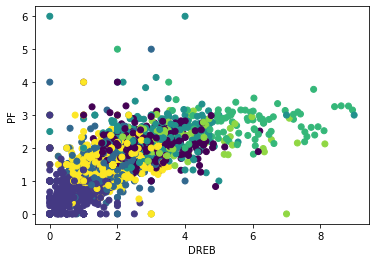

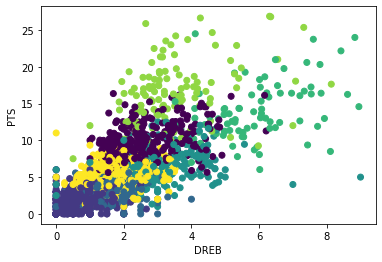

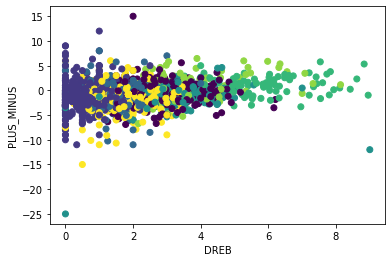

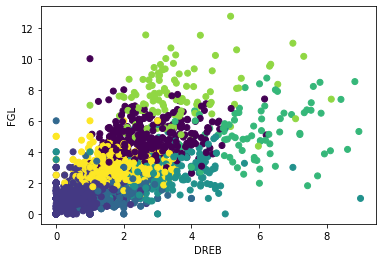

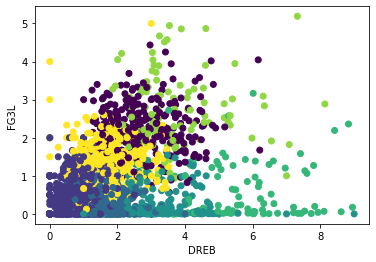

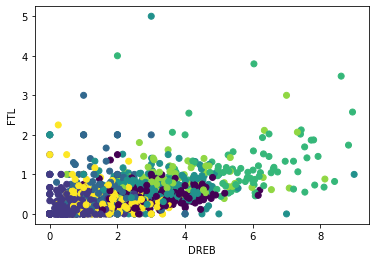

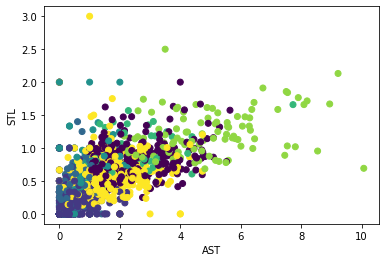

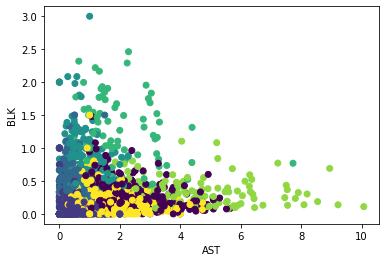

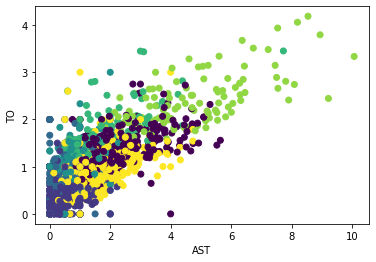

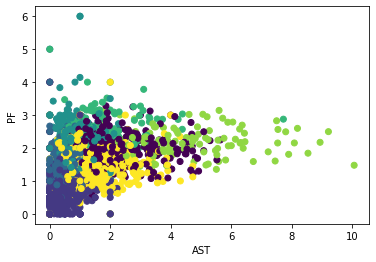

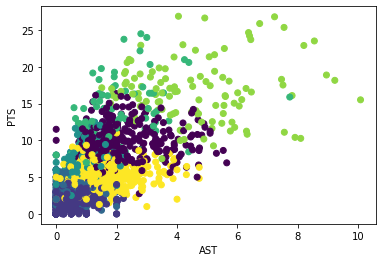

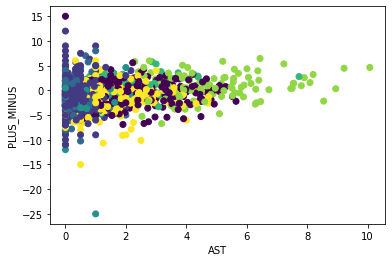

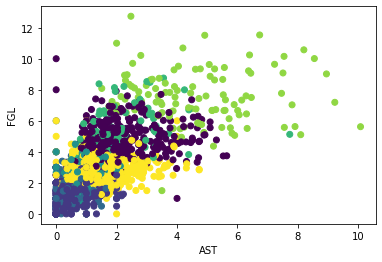

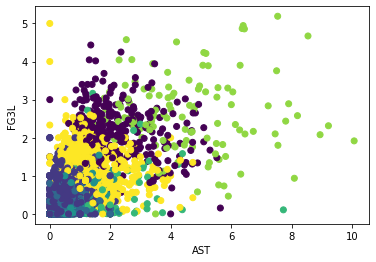

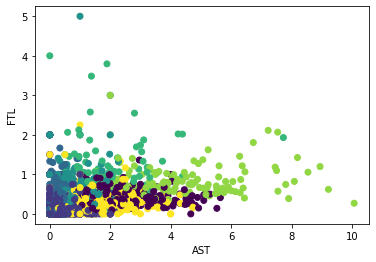

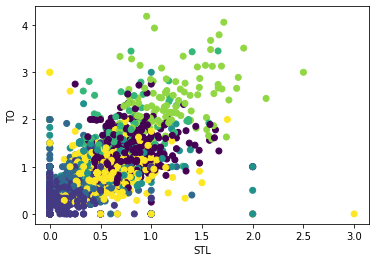

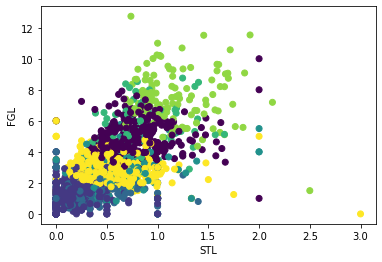

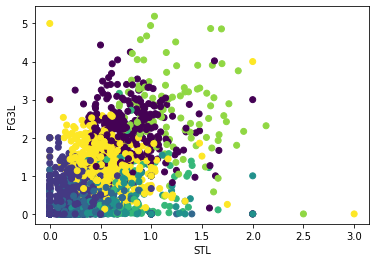

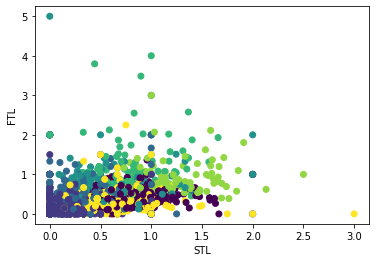

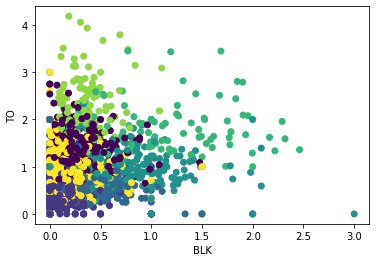

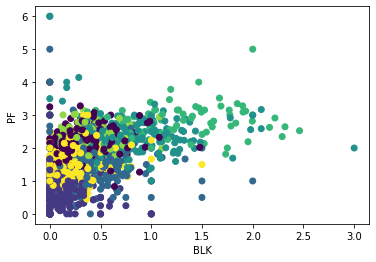

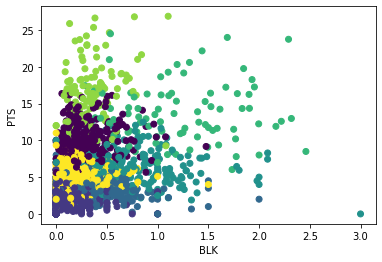

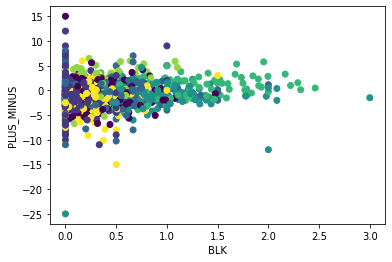

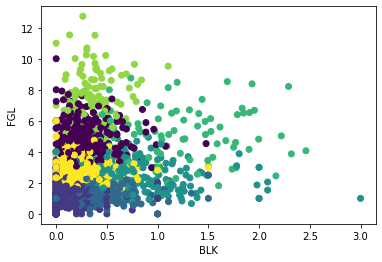

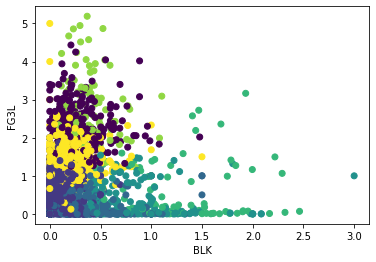

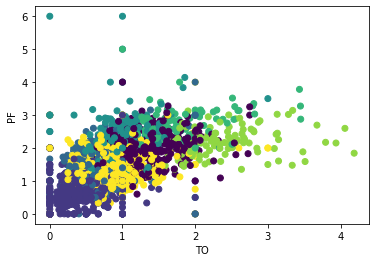

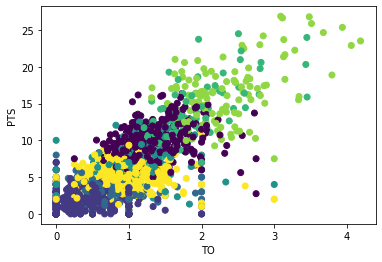

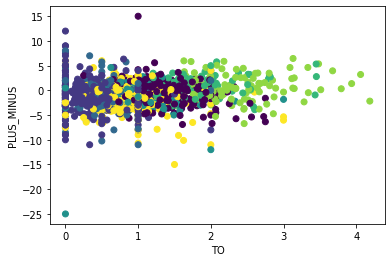

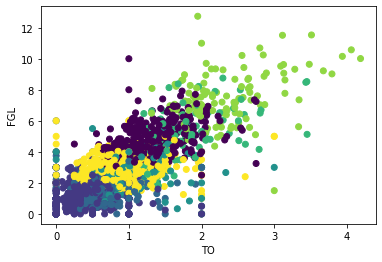

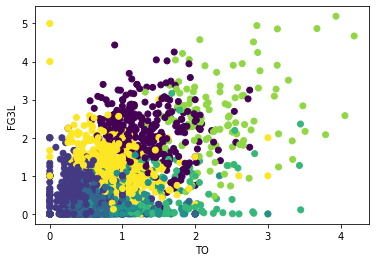

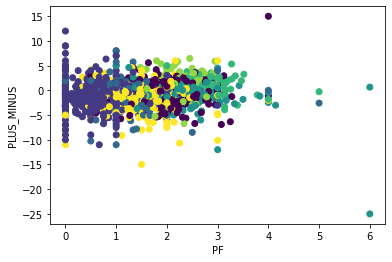

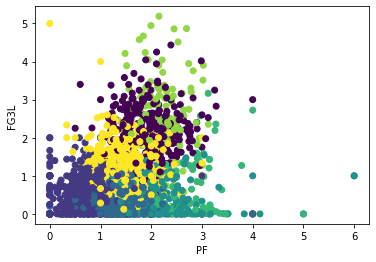

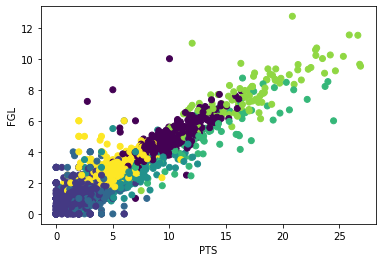

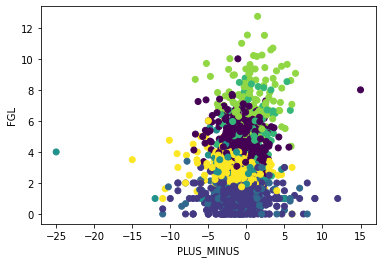

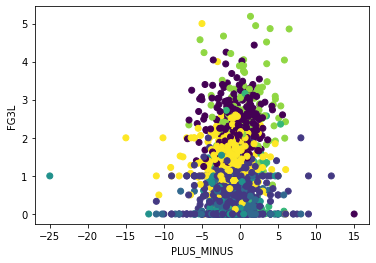

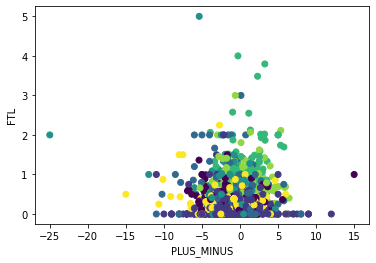

Error in callback <function flush_figures at 0x7f9ec22703b0> (for post_execute):


KeyboardInterrupt: 

In [209]:
# some random graphing

column_pairs = list(itertools.combinations(imputed_player_avgs_df.drop(columns=['PLAYER_ID']).columns,2))
i = 0
for (c1, c2) in column_pairs:
    i += 1
    intertias_plot = plt.figure(i)
    plt.scatter(imputed_player_avgs_df[c1], imputed_player_avgs_df[c2], c=kmeans.labels_)
    plt.xlabel(c1)
    plt.ylabel(c2)

In [216]:
# 7. CLUSTER with KMeans
# 7a. k = 2, does this separate into 'good' and 'bad' players?
matrix = pca_player_avgs
kmeans = KMeans(n_clusters=2, random_state=0).fit(matrix)

# Plot along the first two principal components
plt.scatter(matrix[:,0], matrix[:,1], c=kmeans.labels_)
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.title('Clustering from KMeans and SVD')

Text(0.5, 1.0, 'Clustering from KMeans and SVD')

In [ ]:
# 7b. find an optimal k
inertias = []
silhouette_scores = []
ks = range(2,16)
working_df = svd_top_2_comp[:, :5]  # CHANGE THIS

for k in range(2,16):
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    km = model.fit(working_df)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
    # Add sillhouette score
    silhouette_scores.append(silhouette_score(working_df, km.labels_))
    
# plot inertias
intertias_plot = plt.figure(1)
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)

# plot silhouette
sill_plot = plt.figure(2)
plt.plot(ks, silhouette_scores, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette score')
plt.xticks(ks)

# plot pct change in silhouette
pct_change = []
for i in range(1, len(silhouette_scores)):
    pct_change.append(1 - (1-silhouette_scores[i])/(1-silhouette_scores[i-1]))
pct_change_fig = plt.figure(3)
plt.plot(ks[1:], pct_change, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('pct change in silhouette score')
plt.xticks(ks[1:])

In [218]:
print("shape of input matrix is:", working_df.shape)
kmeans = KMeans(n_clusters=7, random_state=15).fit(working_df)  # CHANGE THIS

#Plot along the first two principal components
clusters_plot = plt.figure(4)
plt.scatter(working_df[:,0], working_df[:,1], c=kmeans.labels_)
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.title('Clustering from KMeans')

# plt.show()
plt.savefig("kmeans_7_clusters_final.png")
print(kmeans.cluster_centers_)

shape of input matrix is: (2434, 5)
[[ 2.6587956  -1.38331922 -0.13100677 -0.5482289  -0.1240571 ]
 [-2.61883048 -0.44963613 -0.10815365  0.20346248  0.26220424]
 [-1.25920038  1.03154191  0.03545685  0.10929025 -0.02857521]
 [ 1.00832513  2.40439086  0.09550418 -0.28472402 -0.31505576]
 [ 5.29873986  3.75585576 -0.45015251  0.06916765  0.47231173]
 [ 6.47062429 -1.78448035  0.19060863  0.94072454  0.31555326]
 [-0.11600151 -0.72488035  0.14845279 -0.08746463 -0.1975716 ]]


Index(['FG3M', 'FTM', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS',
       'PLUS_MINUS', 'FGL', 'FG3L', 'FTL', 'PLAYER_ID'],
      dtype='object')
Index([       'PC1',        'PC2',            2,            3,            4,
            'label',       'FG3M',        'FTM',       'OREB',       'DREB',
              'AST',        'STL',        'BLK',         'TO',         'PF',
              'PTS', 'PLUS_MINUS',        'FGL',       'FG3L',        'FTL'],
      dtype='object')


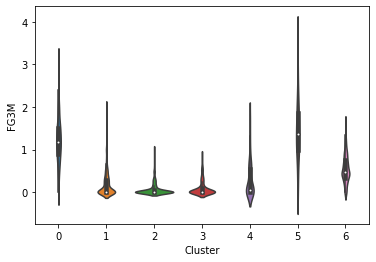

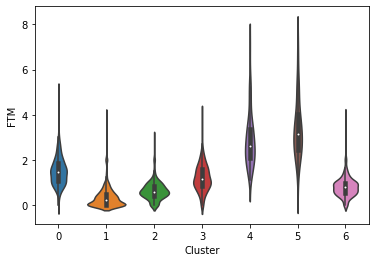

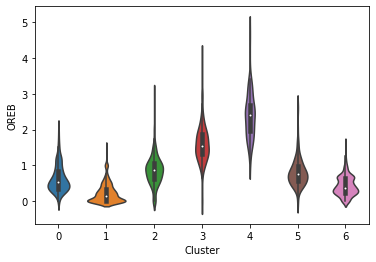

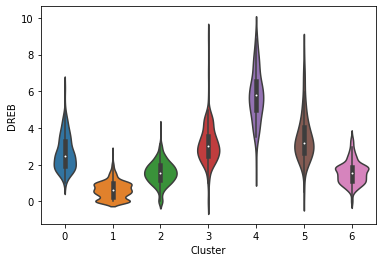

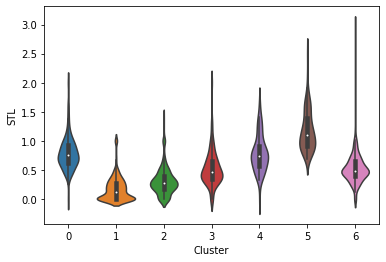

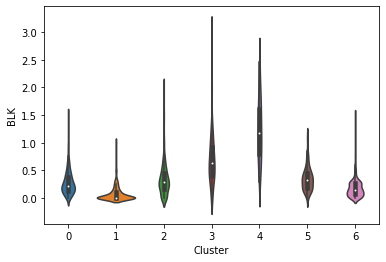

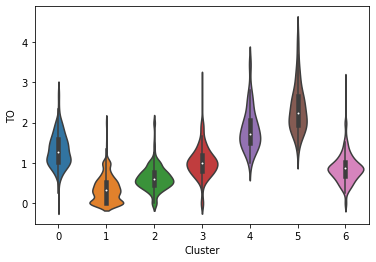

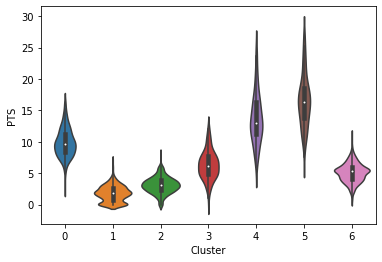

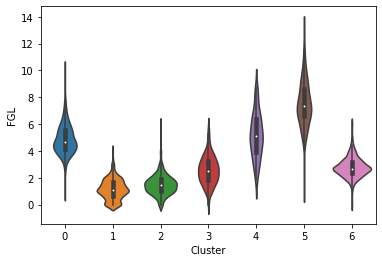

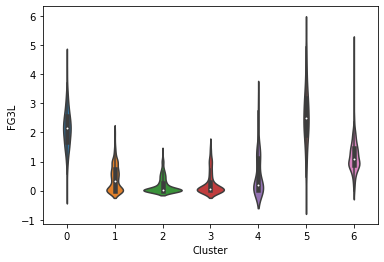

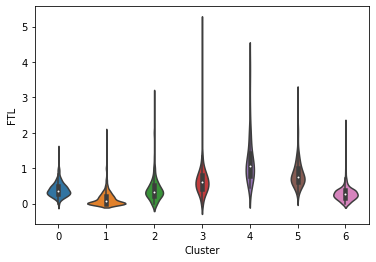

In [246]:
violin_plot_df = pd.DataFrame(working_df)
print(imputed_player_avgs_df.columns)
violin_plot_df['label'] = list(kmeans.labels_)
violin_plot_df.columns.values[0] = 'PC1'
violin_plot_df.columns.values[1] = 'PC2'

fig = plt.figure()
i = 0
for c in imputed_player_avgs_df.columns:
    if c is not "PLAYER_ID":
        fig.add_subplot()
        val = c
        i += 1
        intertias_plot = plt.figure(i)
        violin_plot_df[val] = imputed_player_avgs_df[val]
        ax = sns.violinplot(x='label', y=val, data =violin_plot_df)
        ax.set(xlabel="Cluster",  ylabel=c)
# plt.savefig("violin_plot_PC2")
print(violin_plot_df.columns)

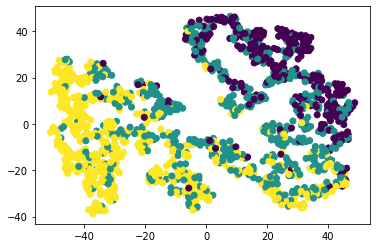

In [79]:
# just trying TSNE for dimensionality reduction
tsne = TSNE(n_components=2, n_iter=2000)
tsne_results = tsne.fit_transform(working_df)
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=preprocessing.LabelEncoder().fit_transform(player_avgs_df['START_POSITION']))

(1405, 5)
(1405, 17)
['C' 'F' 'G']


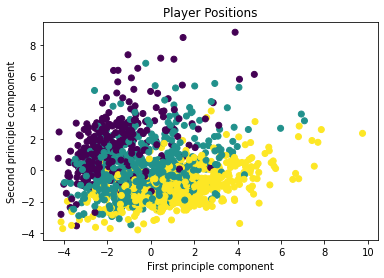

In [192]:
# scatter with classes as positions
print(working_df.shape)
print(player_avgs_df.shape)
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.title('Player Positions')
le = preprocessing.LabelEncoder().fit(player_avgs_df['START_POSITION'])
print(le.classes_)
plt.scatter(working_df[:,0], working_df[:,1], c=le.transform(player_avgs_df['START_POSITION']))
plt.savefig("positions_final.png")

In [199]:
# get stats for positions
position_stats_df = pd.DataFrame()
position_labels = le.transform(player_avgs_df['START_POSITION'])

# C , F, G
for i in range(3):
    indices = np.where(position_labels == i)
    means = player_avgs_df.loc[indices].mean().to_frame().T
    print(means)

       PLAYER_ID      FG3M       FTM      OREB      DREB       AST       STL  \
0  417924.477966  0.185074  1.591154  2.110227  4.377332  1.206099  0.600314   

        BLK        TO        PF       PTS  PLUS_MINUS       FGL      FG3L  \
0  1.025017  1.291222  2.879845  9.012065   -1.512242  3.481153  0.382477   

        FTL  
0  0.783926  
       PLAYER_ID      FG3M       FTM      OREB      DREB      AST       STL  \
0  513311.166362  0.823327  1.615349  1.353523  3.747358  1.66132  0.821391   

        BLK       TO        PF        PTS  PLUS_MINUS       FGL      FG3L  \
0  0.532555  1.30391  2.445433  10.122355   -1.926969  4.774745  1.575081   

        FTL  
0  0.555974  
       PLAYER_ID      FG3M       FTM      OREB      DREB       AST       STL  \
0  520049.033748  1.206041  1.839873  0.648178  2.659105  3.574574  1.026593   

        BLK        TO        PF        PTS  PLUS_MINUS       FGL      FG3L  \
0  0.229603  1.811484  2.183082  11.518957    -2.37839  5.819551  2.265153 

(1405, 5)
(1405, 17)
['C' 'F' 'G']
[2 2 2 ... 1 1 2]


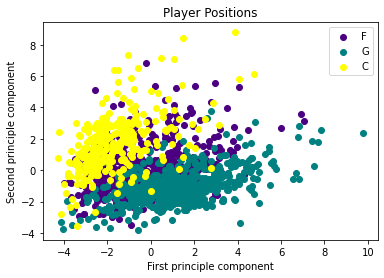

In [156]:
# scatter with classes as positions
print(working_df.shape)
print(player_avgs_df.shape)
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.title('Player Positions')
le = preprocessing.LabelEncoder().fit(player_avgs_df['START_POSITION'])
labels = le.transform(player_avgs_df['START_POSITION'])
print(le.classes_)
print(labels)
for i in [1,2,0]:
    indeces = np.where(labels == i)
    if i == 0:
        label = "C"
        color = "yellow"
    elif i == 1:
        label = "F"
        color = "indigo"
    else:
        label = "G"
        color = "teal"
    plt.scatter(working_df[indeces,0], working_df[indeces,1], c=color, label=label)
plt.legend()
# plt.savefig("C&G.png")

In [210]:
# gather statistics about each label, see if we can discern a latent 'position'
df_copy = player_avgs_df.copy().reset_index()
for label in set(kmeans.labels_):
    idxes = [i for i,x in enumerate(kmeans.labels_) if x == label]
    means = df_copy.loc[idxes].mean().to_frame().T
    print(means)
    print("==========")
    

         index      PLAYER_ID      FG3M       FTM      OREB      DREB  \
0  1170.968153  583900.748408  1.198617  1.503782  0.639293  2.666573   

        AST       STL       BLK       TO        PF       PTS  PLUS_MINUS  \
0  2.238322  0.789191  0.280673  1.32698  1.990164  9.917213    -0.49788   

        FGL      FG3L       FTL  
0  4.863924  2.146322  0.404964  
         index     PLAYER_ID      FG3M       FTM      OREB      DREB  \
0  1443.421296  6.832267e+06  0.166838  0.326546  0.223485  0.633458   

        AST       STL       BLK        TO        PF       PTS  PLUS_MINUS  \
0  0.397547  0.172045  0.075545  0.351445  0.644213  1.765236    -0.95722   

        FGL      FG3L       FTL  
0  1.162016  0.438006  0.137736  
         index     PLAYER_ID      FG3M      FTM      OREB    DREB       AST  \
0  1067.616822  734952.21028  0.063942  0.64127  0.861966  1.5595  0.442715   

       STL       BLK        TO        PF       PTS  PLUS_MINUS       FGL  \
0  0.30474  0.325121  0.62988

In [110]:
# exporting labels and players' avg stats
labels_df = pd.DataFrame()
labels_df['label'] = list(kmeans.labels_)
labels_one_hot_df = pd.get_dummies(labels_df['label'], prefix='label')

print(labels_one_hot_df.shape, labels_one_hot_df.columns)
export_player_avgs_df = pd.concat([player_avgs_df.copy(), labels_one_hot_df], axis=1)

# label_names = ['label_0', 'label_1', 'label_2', 'label_3', 'label_4',
#        'label_5', 'label_6', 'label_7', 'label_8', 'label_9', 'label_10',
#        'label_11']

label_names = ['label_0', 'label_1', 'label_2', 'label_3', 'label_4',
       'label_5', 'label_6']
export_player_avgs_df['centroid_coord'] = np.nan

for label in label_names:
    label_idx = int(label.split('_')[1])
    print(label_idx)
    export_player_avgs_df.loc[export_player_avgs_df[label] == 1,'centroid_coord'] = kmeans.cluster_centers_[label_idx][1]

print(export_player_avgs_df.shape)
print(export_player_avgs_df.columns)
export_player_avgs_df = export_player_avgs_df.drop(['START_POSITION', 'PLAYER_NAME'], axis=1)
export_player_avgs_df.head()
# export_player_avgs_df.to_pickle("./player_avgs_and_labels_k=7.pkl")

(2434, 7) Index(['label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5',
       'label_6'],
      dtype='object')
0
1
2
3
4
5
6
(2434, 25)
Index(['PLAYER_ID', 'PLAYER_NAME', 'START_POSITION', 'FG3M', 'FTM', 'OREB',
       'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS', 'FGL',
       'FG3L', 'FTL', 'label_0', 'label_1', 'label_2', 'label_3', 'label_4',
       'label_5', 'label_6', 'centroid_coord'],
      dtype='object')


PLAYER_ID      FG3M       FTM      OREB      DREB       AST       STL  \
0         15  0.728643  0.407035  0.195980  0.939698  0.577889  0.306533   
1         42  0.000000  0.000000  1.000000  3.000000  0.000000  1.000000   
2         43  0.562500  0.312500  0.187500  0.625000  0.875000  0.375000   
3         56  0.621333  1.424000  0.565333  2.405333  4.296000  0.965333   
4         57  0.461538  1.609467  0.786982  2.899408  3.769231  1.633136   

        BLK        TO        PF  ...      FG3L       FTL  label_0  label_1  \
0  0.065327  0.487437  0.829146  ...  1.165829  0.095477        1        0   
1  0.000000  2.000000  0.000000  ...  0.000000  0.000000        0        0   
2  0.125000  0.375000  0.500000  ...  0.625000  0.062500        1        0   
3  0.144000  1.450667  1.936000  ...  1.512000  0.504000        0        0   
4  0.402367  1.781065  2.147929  ...  1.000000  0.266272        0        0   

   label_2  label_3  label_4  label_5  label_6  centroid_coord  
0        0        0        0        0        0       -0.402549  
1        0        0        0        0        1       -0.717161  
2        0        0        0        0        0       -0.402549  
3        0        1        0        0        0       -1.370740  
4        0        1        0        0        0       -1.370740  

[5 rows x 23 columns]